In [1]:
# Import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting
import seaborn as sns   # plotting heatmap

Loading Data and EDA

In [2]:
data = pd.read_csv("/Users/welpp/Desktop/Practical Data Science/Data/Data Main/goes_13to18.csv",
                   parse_dates=['time'],
                   index_col='time')

In [3]:
data = data[['xrsa_flux', 'xrsb_flux', 'status']]

In [4]:
data.head()

,xrsa_flux,xrsb_flux,status
time,,,
2009-09-01 03:59:00+00:00,1.000000e-09,1.000000e-09,0
2009-09-01 04:00:00+00:00,1.000000e-09,1.000000e-09,0
2009-09-01 04:01:00+00:00,1.000000e-09,1.000000e-09,0
2009-09-01 04:02:00+00:00,1.000000e-09,1.000000e-09,0
2009-09-01 04:03:00+00:00,1.000000e-09,1.000000e-09,0


In [5]:
data.info

<bound method DataFrame.info of                               xrsa_flux     xrsb_flux  status
time                                                         
2009-09-01 03:59:00+00:00  1.000000e-09  1.000000e-09       0
2009-09-01 04:00:00+00:00  1.000000e-09  1.000000e-09       0
2009-09-01 04:01:00+00:00  1.000000e-09  1.000000e-09       0
2009-09-01 04:02:00+00:00  1.000000e-09  1.000000e-09       0
2009-09-01 04:03:00+00:00  1.000000e-09  1.000000e-09       0
...                                 ...           ...     ...
2023-10-02 11:55:00+00:00  1.929477e-09  9.619084e-07       0
2023-10-02 11:56:00+00:00  1.000000e-09  9.546236e-07       0
2023-10-02 11:57:00+00:00  1.000000e-09  9.511839e-07       0
2023-10-02 11:58:00+00:00  1.000000e-09  9.479994e-07       0
2023-10-02 11:59:00+00:00  3.127326e-09  9.438966e-07       0

[7203583 rows x 3 columns]>

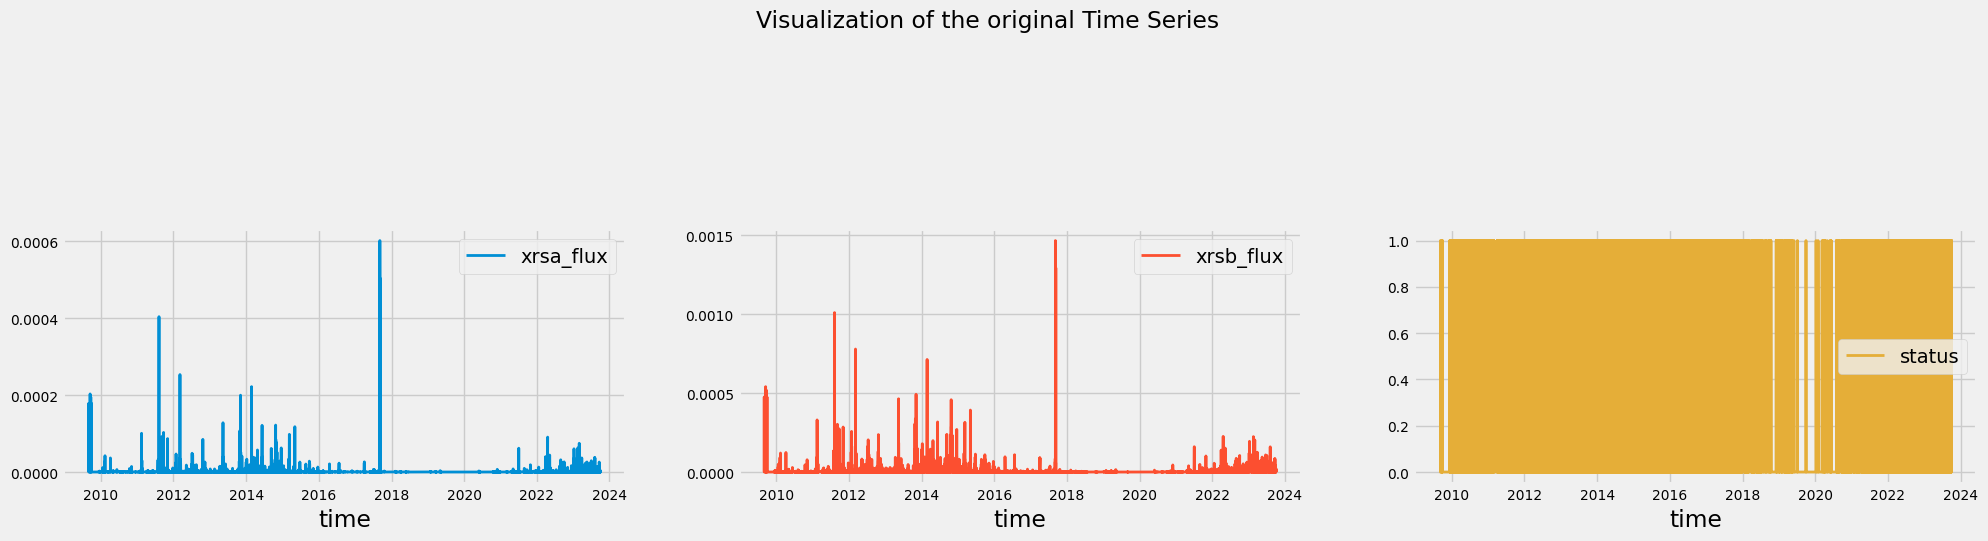

In [6]:
plt.style.use('fivethirtyeight')
data.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

In [7]:
data[:'2022'].tail()

,xrsa_flux,xrsb_flux,status
time,,,
2022-12-31 23:55:00+00:00,4.996568e-09,9.522558e-07,0
2022-12-31 23:56:00+00:00,6.151049e-09,9.515520e-07,0
2022-12-31 23:57:00+00:00,6.601901e-09,9.547597e-07,0
2022-12-31 23:58:00+00:00,7.335534e-09,9.572365e-07,0
2022-12-31 23:59:00+00:00,8.484495e-09,9.689676e-07,0


In [8]:
data['2023-01-09 06:49':'2023-01-09 06:51']

,xrsa_flux,xrsb_flux,status
time,,,
2023-01-09 06:49:00+00:00,0.000057,0.000185,0
2023-01-09 06:50:00+00:00,0.000060,0.000195,0
2023-01-09 06:51:00+00:00,0.000053,0.000179,0


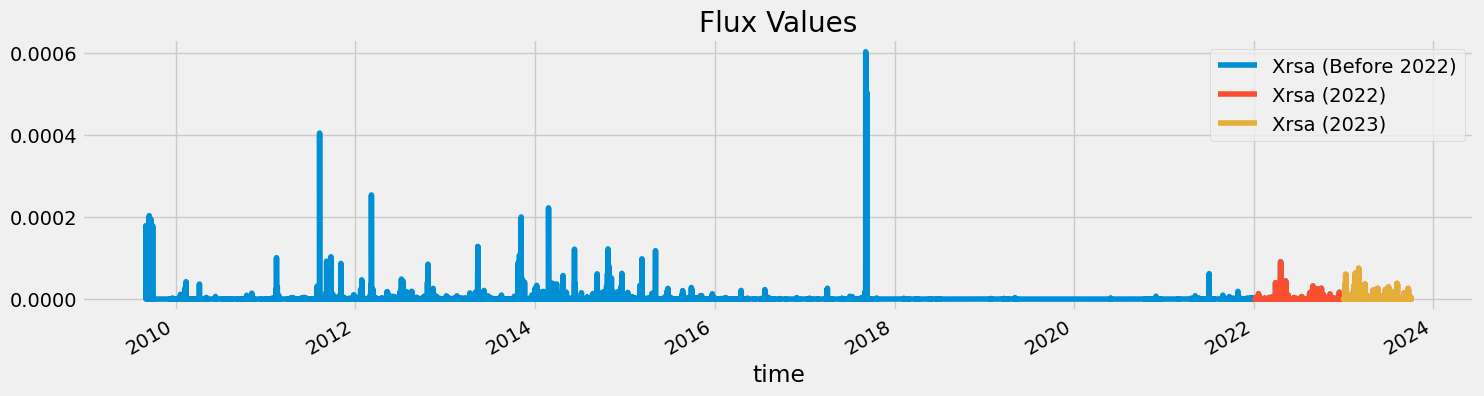

In [9]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
data['xrsa_flux'][:'2022'].plot(figsize=(16,4),legend=True)
data['xrsa_flux']['2022':'2023'].plot(figsize=(16,4),legend=True)
data['xrsa_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Flux Values')
plt.show()

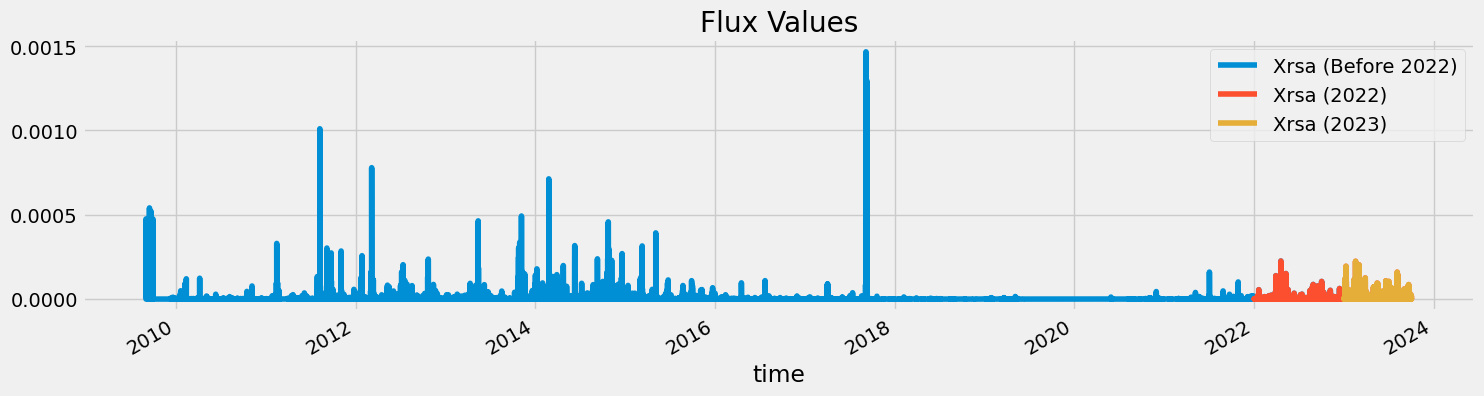

In [10]:
data['xrsb_flux'][:'2022'].plot(figsize=(16,4),legend=True)
data['xrsb_flux']['2022':'2023'].plot(figsize=(16,4),legend=True)
data['xrsb_flux']['2023':].plot(figsize=(16,4),legend=True)
plt.legend(['Xrsa (Before 2022)','Xrsa (2022)', 'Xrsa (2023)'])
plt.title('Flux Values')
plt.show()

Text(0, 0.5, 'xrsb_flux')

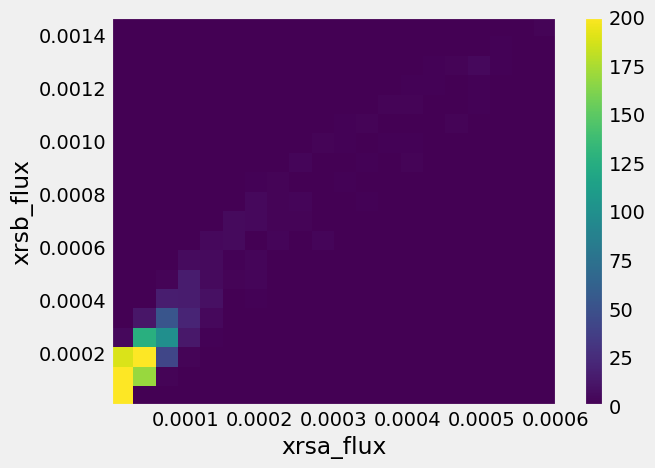

In [11]:
plt.hist2d(data['xrsa_flux'], data['xrsb_flux'], bins=(20, 20), vmax=200)
plt.colorbar()
plt.xlabel('xrsa_flux')
plt.ylabel('xrsb_flux')

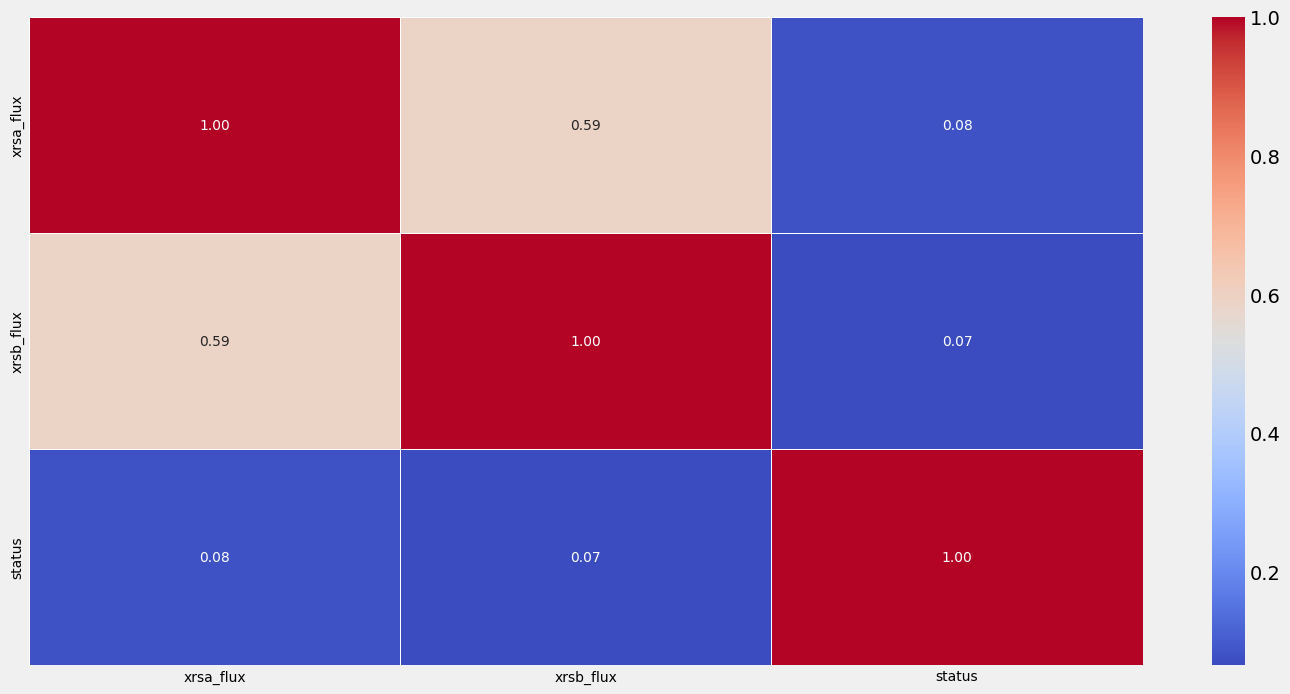

In [12]:
corr_matrix = data.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Data Processing

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
df = data.copy()

In [6]:
flux = df[['xrsa_flux','xrsb_flux']]

In [7]:
## minmax scaling flux values only
scaler = MinMaxScaler(feature_range=(0, 1))
flux = scaler.fit_transform(flux)

In [8]:
df['xrsa_flux'] = flux[:,0]
df['xrsb_flux'] = flux[:,1]

In [9]:
df.tail()

,xrsa_flux,xrsb_flux,status
time,,,
2023-10-02 11:55:00+00:00,0.000002,0.000655,0
2023-10-02 11:56:00+00:00,0.000000,0.000650,0
2023-10-02 11:57:00+00:00,0.000000,0.000648,0
2023-10-02 11:58:00+00:00,0.000000,0.000646,0
2023-10-02 11:59:00+00:00,0.000004,0.000643,0


In [10]:
## data splits
train = df[:'2022'].to_numpy()
val = df['2022':'2023'].to_numpy()
test = df['2023':].to_numpy()

In [20]:
test[:,:]

array([[1.28654639e-05, 6.67840356e-04, 0.00000000e+00],
       [1.24912465e-05, 6.70470325e-04, 0.00000000e+00],
       [1.14385149e-05, 6.71215198e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 6.48025651e-04, 0.00000000e+00],
       [0.00000000e+00, 6.45853834e-04, 0.00000000e+00],
       [3.53374379e-06, 6.43055732e-04, 0.00000000e+00]])

In [11]:
X_train_xrsa = []
X_train_xrsb = []
y_train = []
X_val_xrsa = []
X_val_xrsb = []
y_val = []
X_test_xrsa = []
X_test_xrsb = []
y_test = []
timesteps = 50

for i in range(len(train) - timesteps):
    X_train_xrsa.append(train[i:i + timesteps, 0])
    X_train_xrsb.append(train[i:i + timesteps, 1])
    y_train.append(train[i + timesteps,2])

for i in range(len(val) - timesteps):
    X_val_xrsa.append(val[i:i + timesteps, 0])
    X_val_xrsb.append(val[i:i + timesteps, 1])
    y_val.append(val[i + timesteps,2])

for i in range(len(test) - timesteps):
    X_test_xrsa.append(test[i:i + timesteps, 0])
    X_test_xrsb.append(test[i:i + timesteps, 1])
    y_test.append(test[i + timesteps,2])

In [12]:
X_train_a, X_train_b = np.array(X_train_xrsa), np.array(X_train_xrsb)
y_train = np.array(y_train)

In [13]:
X_train = np.stack((X_train_a, X_train_b), axis = 2)

In [14]:
print(X_train.shape)
print(y_train.shape)

(6812700, 50, 2)
(6812700,)


Model Building

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D

In [18]:
## LSTM Model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10600     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10651 (41.61 KB)
Trainable params: 10651 (41.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train, epochs=2, batch_size=64)

Epoch 1/2
106449/106449 [==============================] - 1299s 12ms/step - loss: 707044.2500 - accuracy: 0.9960
Epoch 2/2
 27702/106449 [======>.......................] - ETA: 17:01 - loss: 0.2386 - accuracy: 0.9959

In [ ]:
sum(y_train)/len(y_train)